In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('course_lead_scoring.csv')

In [4]:
df.head()

lead_source    industry  number_of_courses_viewed  annual_income  \
0      paid_ads         NaN                         1        79450.0   
1  social_media      retail                         1        46992.0   
2        events  healthcare                         5        78796.0   
3      paid_ads      retail                         2        83843.0   
4      referral   education                         3        85012.0   

  employment_status       location  interaction_count  lead_score  converted  
0        unemployed  south_america                  4        0.94          1  
1          employed  south_america                  1        0.80          0  
2        unemployed      australia                  3        0.69          1  
3               NaN      australia                  1        0.87          0  
4     self_employed         europe                  3        0.62          1

In [ ]:
Data preparation
Check if the missing values are presented in the features.
If there are missing values:
For caterogiral features, replace them with 'NA'
For numerical features, replace with with 0.0
Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1


In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')
    df[c] = df[c].fillna('NA')

for n in numerical_columns:
     df[n] = df[n].fillna(0)

In [7]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

df_train_copy = df_train.copy()
del df_train['converted']
del df_val['converted']
del df_test['converted']

In [ ]:
ROC AUC could also be used to evaluate feature importance of numerical variables.
Lets do that
For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front
(e.g. -df_train['balance'])
AUC can go below 0.5 if the variable is negatively correlated with the target variable.
You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.
Which numerical variable (among the following 4) has the highest AUC?
lead_score
number_of_courses_viewed
interaction_count
annual_income

Answer is number_of_courses_viewed

In [8]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

columns = ['lead_score',
'number_of_courses_viewed',
'interaction_count',
'annual_income']

# 2. Initialize the scaler
scaler = StandardScaler()

df_train_scaled = df_train.copy()
# 3. Fit and transform only numeric columns
df_train_scaled[columns] = scaler.fit_transform(df_train[columns])

scores = []
for c in columns:
    auc = roc_auc_score(y_train, df_train_scaled[c])
    scores.append(auc)

scores_df = pd.DataFrame({
    'Feature': columns,
    'ROC_AUC': scores
})

print(scores_df)

                    Feature   ROC_AUC
0                lead_score  0.614499
1  number_of_courses_viewed  0.763568
2         interaction_count  0.738270
3             annual_income  0.551958


In [ ]:
Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)
0.32
0.52
0.72
0.92

In [9]:
from sklearn.feature_extraction import DictVectorizer

numeric_cols = [c for c in numerical_columns if c != 'converted']

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numeric_cols].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_columns + numeric_cols].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [10]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
# solver='lbfgs' is the default solver in newer version of sklearn
# for older versions, you need to specify it explicitly
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [ ]:
LogisticRegression(max_iter=1000, solver='liblinear')
In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org.

In [11]:
model.intercept_[0]

np.float64(-0.10464329280767921)

In [12]:
model.coef_[0]

array([-1.70311954e-05, -2.70081136e-02,  3.53370481e-02, -9.86757745e-03,
        1.37309559e-02, -1.16835606e-01, -2.20831257e-02,  3.31653305e-02,
       -7.86976322e-03, -2.34146287e-02, -6.79204328e-03, -3.28352253e-02,
       -2.71803966e-02, -1.76334405e-02,  3.25593815e-01,  3.19698115e-02,
        3.39339243e-04, -4.68283380e-03, -2.35995158e-02, -1.12097463e-01,
        6.95060080e-02, -3.41088270e-02,  4.97267101e-03, -1.20171327e-02,
       -9.92570215e-03, -2.76412116e-02, -1.33322515e-02, -1.89990320e-02,
       -2.27905151e-02, -4.91011865e-03,  4.52528283e-01])

In [13]:
y_pred_scores = model.decision_function(X_val)

In [14]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred

array([0.57539503, 0.47060769, 0.61901236, 0.6143892 , 0.61741031,
       0.67496748, 0.8465351 , 0.38205016, 0.55735358, 0.91246751,
       0.77549359, 0.66110422, 0.91574386, 0.38389183, 0.88197523,
       0.89511778, 0.65336369, 0.53077648, 0.73106703, 0.70418456,
       0.78080321, 0.51381844, 0.88869813, 0.72195815, 0.91633086,
       0.53483932, 0.50123084, 0.84175873, 0.48497478, 0.60635462,
       0.63002389, 0.50197705, 0.54916065, 0.91861628, 0.6902664 ,
       0.65666092, 0.84766044, 0.79947504, 0.47461069, 0.63286015,
       0.82887379, 0.4355907 , 0.45453631, 0.58816791, 0.64477414,
       0.73619001, 0.53893927, 0.71596383, 0.74170518, 0.86747808,
       0.77685777, 0.75943833, 0.84663023, 0.67334212, 0.78059001,
       0.68835976, 0.63561826, 0.56955796, 0.6699862 , 0.75372267,
       0.33388224, 0.68155641, 0.35336533, 0.7745121 , 0.51403962,
       0.2620089 , 0.66844162, 0.41567479, 0.49375719, 0.54251895,
       0.85677057, 0.39794252, 0.46701359, 0.85106564, 0.77222

In [15]:
converted_decision = (y_pred >= 0.5)
(y_val == converted_decision).mean()

np.float64(0.6996587030716723)

In [16]:
from sklearn.metrics import roc_auc_score

In [17]:
score = round(roc_auc_score(y_val, y_pred),3)

In [18]:

print(score)

0.817


In [ ]:
This score is closest to 0.92. Hence selecting 0.92 as answer

Question 3: Precision and Recall
Now let's compute precision and recall for our model.
Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

0.145
0.345
0.545
0.745

Ans: 0.745

In [19]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
scores = []
thresholds = np.linspace(0, 1, 101)
for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [20]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)

threshold   tp   fp  fn  tn  recall  precision
0       0.00  171  122   0   0     1.0   0.583618
1       0.01  171  122   0   0     1.0   0.583618
2       0.02  171  122   0   0     1.0   0.583618
3       0.03  171  122   0   0     1.0   0.583618
4       0.04  171  122   0   0     1.0   0.583618

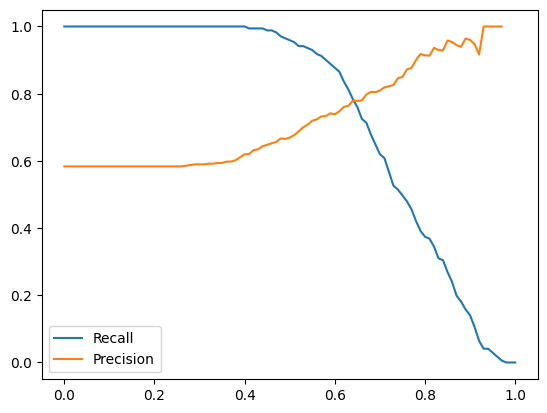

In [21]:
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.legend()
df_scores.head()

In [22]:
df_scores.tail()

threshold  tp  fp   fn   tn    recall  precision
96        0.96   3   0  168  122  0.017544        1.0
97        0.97   1   0  170  122  0.005848        1.0
98        0.98   0   0  171  122  0.000000        NaN
99        0.99   0   0  171  122  0.000000        NaN
100       1.00   0   0  171  122  0.000000        NaN

In [ ]:
The precision and Recall Curves intersect at threshold = 0.745. Hence Answer is 0.745

Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

In [ ]:
F 1
2 ⋅ P ⋅ R P + R

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01
At which threshold F1 is maximal?
0.14
0.34
0.54
0.74
Ans: 0.54

In [23]:
df_scores['F1_score'] = (2*df_scores.precision*df_scores.recall)/ (df_scores.precision + df_scores.recall)

In [24]:
f1_score_max = df_scores.F1_score.max()

In [25]:
df_scores[(df_scores.F1_score == f1_score_max)]

threshold   tp  fp  fn  tn    recall  precision  F1_score
57       0.57  156  57  15  65  0.912281   0.732394    0.8125

In [ ]:
So at threshold 0.57 the F1_score is maximal.Hence closest answer is 0.54

Question 5: 5-Fold CV Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:
KFold(n_splits=5, shuffle=True, random_state=1)
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
Use AUC to evaluate the model on validation
How large is standard deviation of the scores across different folds?

0.0001
0.006
0.06
0.36

Ans: Standard Deviation is 0.035 which is closer to 0.06. Hence Answer is 0.06

In [26]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical_columns + numeric_cols].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [27]:
dv, model = train(df_train, y_train, C=0.001)

In [28]:
def predict(df, dv, model):
    dicts = df[categorical_columns + numeric_cols].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [29]:
y_pred = predict(df_val, dv, model)

In [30]:
from sklearn.model_selection import KFold

In [31]:
!pip install tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
Requirement already satisfied: tqdm in /home/codespace/.python/current/lib/python3.12/site-packages (4.67.1)

In [33]:
from tqdm.auto import tqdm

In [34]:
n_splits = 5

#for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('Mean score across 5 folds are ', np.mean(scores))
print('Standard Deviation acorss 5 folds is' ,  np.std(scores))

Mean score across 5 folds are  0.8221089148573075
Standard Deviation acorss 5 folds is 0.03580711942905165


In [ ]:
Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C
Iterate over the following C values: [0.000001, 0.001, 1]
Initialize KFold with the same parameters as previously
Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?
0.000001
0.001
1
If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.
Ans is 0.001. I am getting best mean score for C= 0.001. Mean score is 0.867

In [ ]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, round(np.mean(scores),3), round(np.std(scores),3)))